# FBP demo 3 - top-down fan beam reconstruction of a single slice

-----------------------------------------------------------------------------------------------------------------------

<u>*The material provided in this notebook can be freely used and modified for educational purposes only. Please cite any content of the notebook as follows:*</u>

- *Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. Available from: https://www.taylorfrancis.com/books/9780429270239*

*For questions, notifications of bugs, or even just for feedback, please contact the authors directly (daniele.panetta@ifc.cnr.it; niccolo.camarlinghi@gmail.com)*

-----------------------------------------------------------------------------------------------------------------------

### Introduction

This demo is different from the two previous ones, as we will not use DAPHNE to reconstruct a single slice of the Shepp-Logan head phantom in 2D fan beam geometry. Indeed, DAPHNE will be used again just to forward project the voxelised phantom and to generate the sinogram to be reconstructed.
The idea behind this demo is to let the reader see the internal steps of computation involved in FBP reconstructions, i.e., all the steps that were just hidden in the method ```Reconstruct()``` of the DAPHNE ```FBP``` class.
We still need to import some useful library from DAPHNE in order to compute the sinogram.

In [2]:
import sys
import numpy as np
sys.path.append("../") # this to be able to include all the object contained in the modules
from Misc.Utils import Unpickle,ReadImage
import matplotlib.pyplot as plt
# set the default size of all the plots 5x5 inches
plt.rcParams['figure.figsize'] = [5, 5]
from Algorithms.SinogramGenerator import SinogramGenerator
#from Algorithms.FBP import FBP
from Geometry.ExperimentalSetupCT import ExperimentalSetupCT,Mode,DetectorShape
from Misc.Preview import Visualize3dImage

%matplotlib notebook

### Create a CT experimental setup

In [3]:
# create CT experimental setup
my_experimental_setup = ExperimentalSetupCT()
my_experimental_setup.mode = Mode.FANBEAM
# detector 
my_experimental_setup.pixels_per_slice_nb=256
my_experimental_setup.detector_slice_nb=1
my_experimental_setup.slice_pitch_mm=1
my_experimental_setup.detector_shape=DetectorShape.PLANAR

# sources 
my_experimental_setup.sdd_mm=750
my_experimental_setup.sad_mm=500
my_experimental_setup.fan_angle_deg=40
# number of rotation of the gantry
my_experimental_setup.gantry_angles_nb = 360
# range of the rotation
my_experimental_setup.angular_range_deg = 360
# fov size in mm 
my_experimental_setup.image_matrix_size_mm = np.array([256,256,1])
# voxel size in mm
my_experimental_setup.voxel_size_mm = np.array([1,1,1])
# compute the geometry
my_experimental_setup.Update()
print(my_experimental_setup.GetInfo())


detector_type: DetectorType.CT
mode: Mode.FANBEAM
pixels_per_slice_nb: 256
detector_slice_nb: 1
slice_pitch_mm: 1
detector_shape: DetectorShape.PLANAR
sdd_mm: 750
sad_mm: 500
fan_angle_deg: 40
gantry_angles_nb: 360
angular_range_deg: 360
image_matrix_size_mm: [256 256   1]
voxel_size_mm: [1 1 1]
number of projections: 92160


### Display the experimental setup

Close the interactive window in order to proceed with subsequent cells, otherwise set ```use_jupyter=1```.

In [4]:
my_experimental_setup.Draw(use_jupyter=0,camera_pos_mm=(0,-900,140))

### Load the image used to generate the sinogram

In this example, we will employ the 2D version of the S-L head phantom, with a finer grid in the $x,y$ plane (256x256) than used in the previous 3D examples. Moreover, unlike the previous example where the dataset was stored in integer format (```np.int32```), this 2D dataset is stored in single precision floating point format (```np.float32```).

<IPython.core.display.Javascript object>


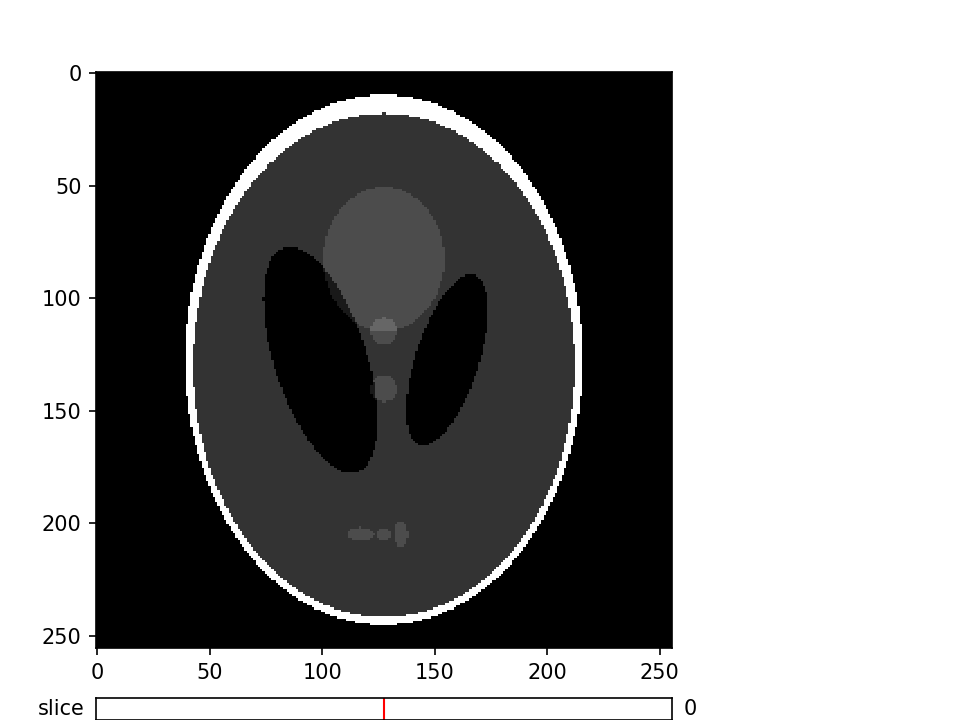

..\Misc\Preview.py:30: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  slider = Slider(ax, 'slice', slice_min, slice_max,valinit=0, valfmt='%i')


In [5]:
phantom = np.fromfile("../Data/SL_HC_256x256.raw",dtype=np.float32).reshape((256,256,1))
Visualize3dImage(phantom,2)


### Generate and display the sinogram

Let us now generate our sinogram data in fan beam geometry, using the geometry parameters defined above in ```my_experimental_setup```.

In [6]:
s=SinogramGenerator(my_experimental_setup)
sino=s.GenerateObjectSinogram(np.flipud(phantom),transponse_image=1)


And let's see it:

mag = 1.5
det_pitch (virtual det., mm) =  1.421758727602353


<IPython.core.display.Javascript object>


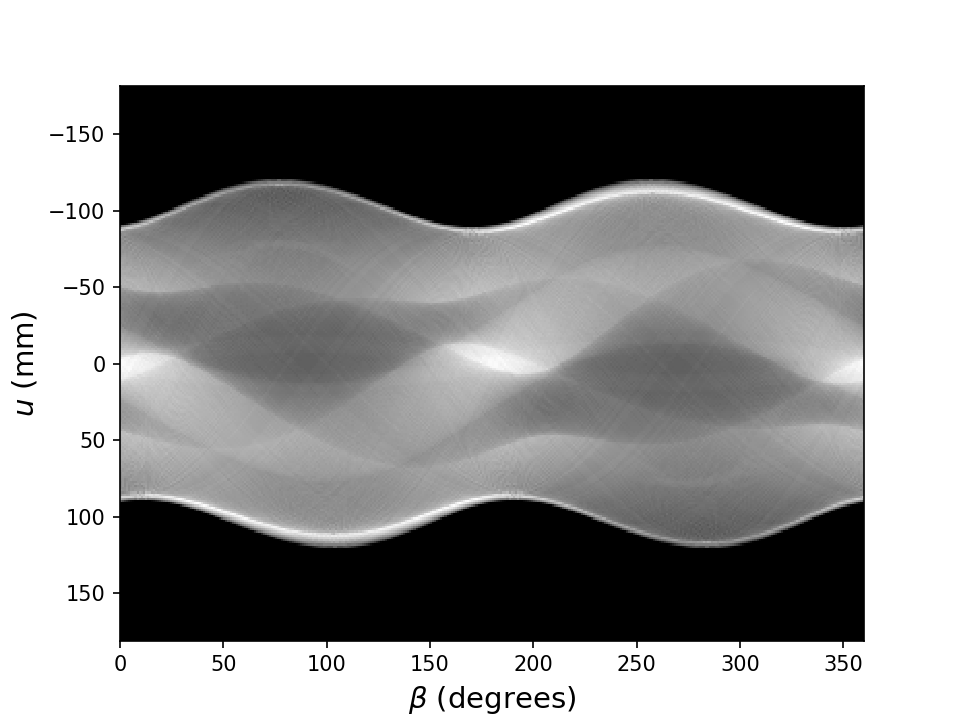

Text(0, 0.5, '$u$ (mm)')

In [7]:
# Create an array with the radial coordinates
# of the (virtual) detector pixels, denoted by u_det
N_rad = my_experimental_setup.pixels_per_slice_nb                       # number of radial bins (detection elements)
mag = my_experimental_setup.sdd_mm / my_experimental_setup.sad_mm       # magnification (SDD/SAD)
virt_det_pitch_mm = my_experimental_setup._detector_pitch_mm / mag      # pitch of virtual detector (= pitch of real det / mag)
u_det = (np.arange(N_rad) - N_rad // 2 + 0.5) * virt_det_pitch_mm       # array of radial coordinates of virtual detector

print("mag =", mag)
print("det_pitch (virtual det., mm) = ", virt_det_pitch_mm)

plt.figure()
plt.gray()
img = plt.imshow(sino._data[:,:,0], extent=[0,360,u_det[N_rad-1], u_det[0]], aspect='auto')
plt.xlabel(r"$\beta$ (degrees)", fontsize=14)
plt.ylabel(r"$u$ (mm)", fontsize=14)


### Ramp filtering of sinogram in frequency domain

#### Generation of the ramp filter
In order to apply ramp filtering to each radial slice of the sinogram, we must first create the filter itself. To this purpose, we will first implement its impulse response function as explained in Chapter 3 of the book (https://www.taylorfrancis.com/books/9780429270239).

In [8]:
filter_size = sino._radial_bins
h = np.zeros((filter_size))

# find all the indices that are odd with respect to filter_size/2
idx = np.arange(0, filter_size, 2) 
f_center=filter_size // 2 + 1 - filter_size%2
h[idx] = -(((idx - f_center) * np.pi) ** 2)

# extract those indices at which the value of h is not null and make reciprocal
nnull = h != 0
h[nnull] = 1 / h[nnull]

#define the filter value at center
h[f_center] = 1 / 4

# compute fft to generate the frequency response of the filter (the ramp)
ramp = np.fft.fft(h) * sino._radial_step_mm / 2
H = abs(ramp) # take the magnitude of the complex FFT


Let's display the filter in both spatial and frequancy domain.

<IPython.core.display.Javascript object>


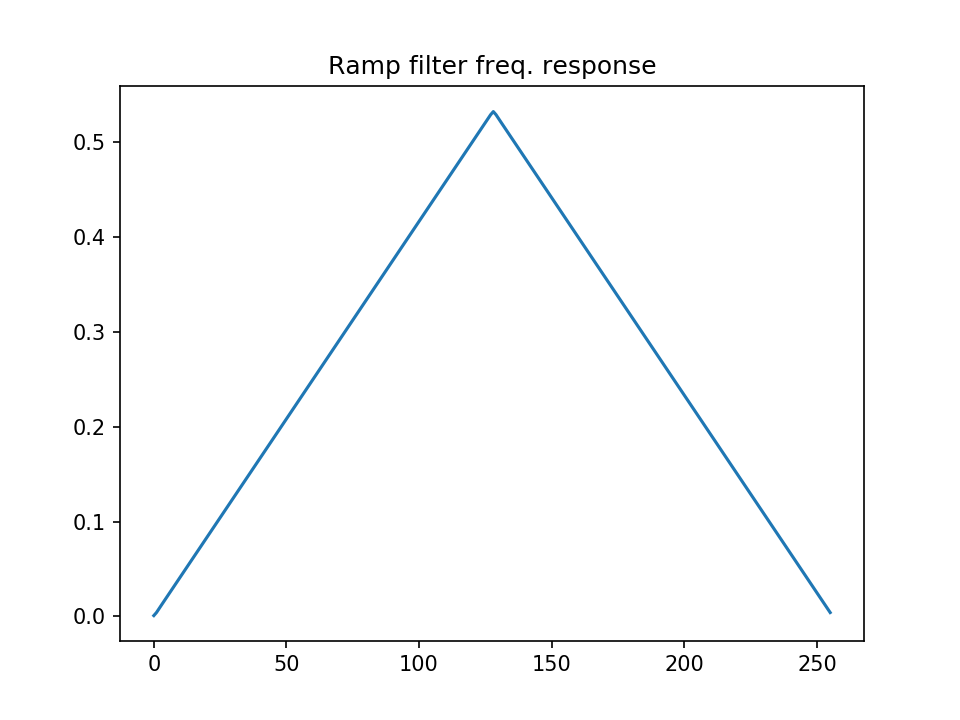

<IPython.core.display.Javascript object>


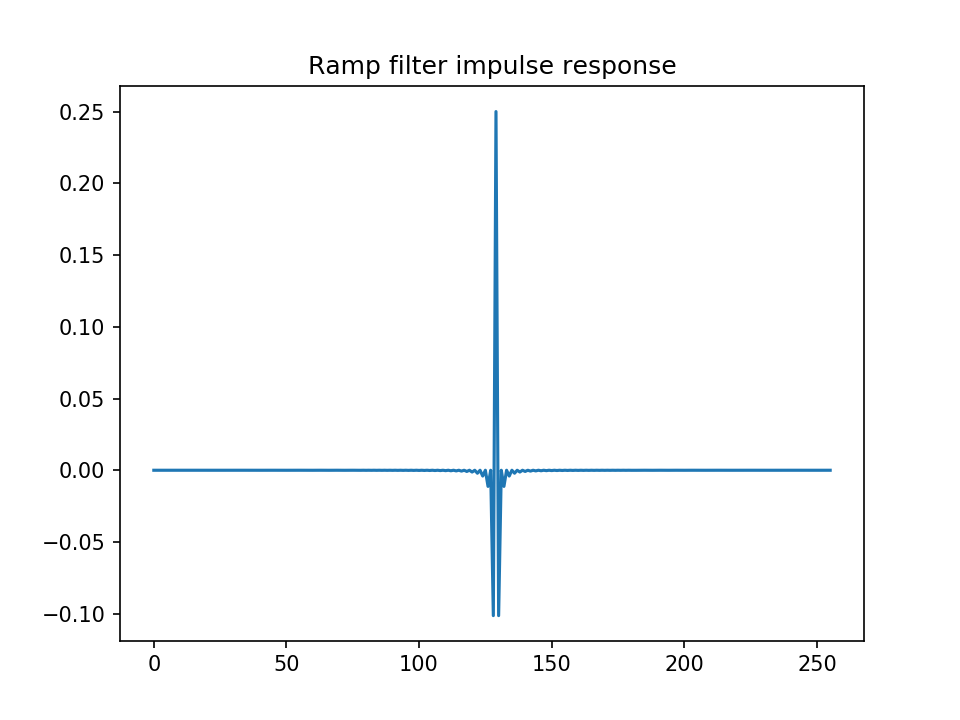

In [9]:
plt.figure()
plt.plot(H)
plt.title("Ramp filter freq. response")

plt.figure()
plt.title("Ramp filter impulse response")
plt.plot(h)

Now, the pythonization of the algorithm leads us to create a copy of the 1D frequency response function $H(\nu)$ for all the radial slices of the sinogram, in such a way that the filtration in the frequency domain is just performed as element-wise multiplication of numpy arrays.

In [10]:
# this last step creates a matrix where each column contains H
Hm = np.array([H] * sino._angular_bins)
Hm = np.transpose(Hm)
Hm = np.tile(Hm,sino._z_bins).reshape(sino._radial_bins,sino._angular_bins,-1)

print(Hm.shape)

(256, 360, 1)


#### Sinogram weighting and filtration in the frequency domain
We are now ready to compute the 1D FFT of each radial slice of the sinogram, applying the ramp filter and the compute the inverse FFT line by line to get the filtered sinogram.
Before doing that, we remember that a weighting step is required in divergent geometry.

In [11]:
# Sinogram weighting factor
D = my_experimental_setup.sad_mm
w = D / np.sqrt(np.square(D) + np.square(u_det))   

# Same trick used for the Hm matrix: let's convert the 1d weighting function to a matrix
wm = np.array([w] * sino._angular_bins)
wm = np.transpose(wm)
wm = np.tile(wm,sino._z_bins).reshape(sino._radial_bins,sino._angular_bins,-1)


# Weight sinogram
wsino = sino._data * wm

After weighting, the sinogram can be ramp-filtered in the frequency domain.

In [12]:
fft1d_sinogram = np.fft.fft(wsino, axis=0)  # this stores the 1D FFT of all the sinogram lines
filtsino = np.real(np.fft.ifft(fft1d_sinogram * Hm, axis=0))   # and this stores the filtered sinogram

Let's display the filtered sinogram:

<IPython.core.display.Javascript object>


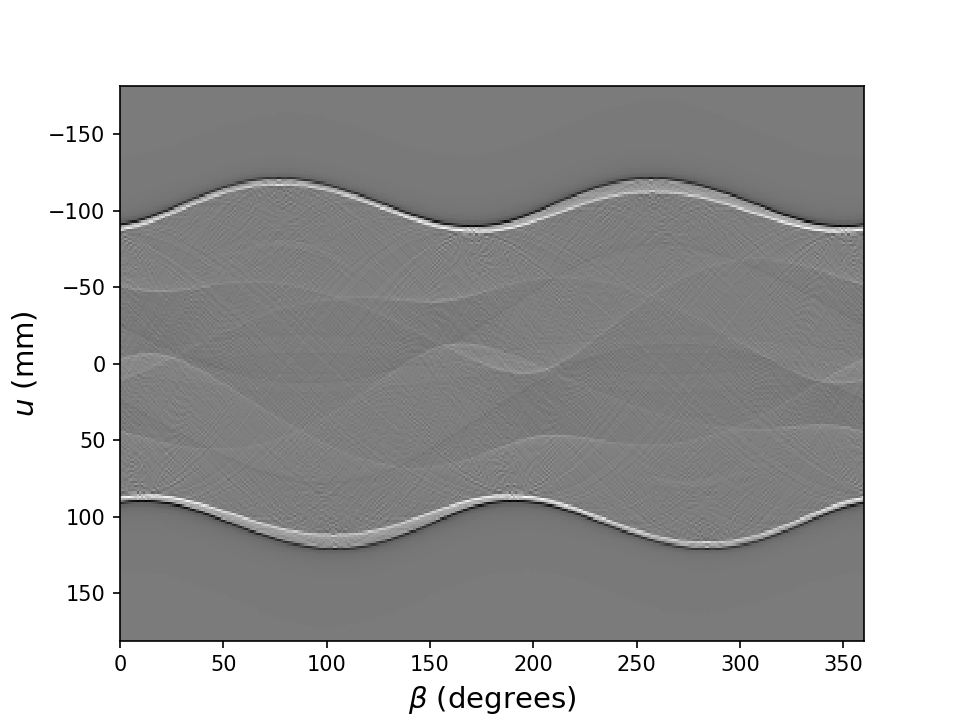

Text(0, 0.5, '$u$ (mm)')

In [13]:
plt.figure()
plt.gray()
img = plt.imshow(filtsino[:,:,0], extent=[0,360,u_det[N_rad-1], u_det[0]], aspect='auto')
plt.xlabel(r"$\beta$ (degrees)", fontsize=14)
plt.ylabel(r"$u$ (mm)", fontsize=14)

### Backprojection (single step)

#### Preparatory steps
Now, we must backproject the filtered sinogram obtained in the above steps. Let us first import the ```interp1d``` function from ```scipy.interpolate```.

In [14]:
from scipy.interpolate import interp1d

Now, let's create a target image as a 2D numpy array, initially set to zero everywhere. We will set the side of the recon matrix equal to the number of radial bins per detector row (256 in this example).

In [15]:
# Set the side of a squared target image
Imsize = my_experimental_setup.pixels_per_slice_nb
img_partial = np.zeros([Imsize,Imsize], dtype=float)

We must now create a grid containing the polar coordinates of each pixel in the recon matrix. To do that, we first create the grid of cartesian coordinates.

In [16]:
# Grid of the coordinates of the pixel centers
# in the target image (pitch=1 for simplicity)
x,y = np.mgrid[:Imsize, :Imsize] - Imsize // 2 + 0.5
y = y*(-1)
r=np.sqrt(np.square(x)+np.square(y))
varphi=np.arctan2(y,x)

#### Weighting factors
As explained in Chapter 3 of the book, a specific weghting factor, $W_{BP}$, must be used in the backprojection step in divergent geometry. Let's define it in the next cell.

In [17]:
# Create an array with the gantry angles
N_ang = my_experimental_setup.gantry_angles_nb
beta_deg = np.arange(0, N_ang, 1)

# This tuple stores the projection (1D array) 
# at the selected angle and the corresponding
# gantry angle in radians
(filtproj, beta_rad) = (filtsino[:,id_proj,0],
                     np.deg2rad(beta_deg)[id_proj])


# Auxiliary weights for backprojection
U = D + r * np.sin(varphi-beta_rad)

# The following lines are relevant for arc-shaped detector
#L = np.sqrt(np.square(U)+np.square(r*np.cos(varphi-beta_rad)))
#gamma_p = np.arccos(U/L) * np.sign(np.cos(varphi-beta_rad))

# This is the backprojection weigting factor for the flat detector
W_BP = np.square(U)


In the next step, we will select a single gantry angle to be backprojected in a partial image. For instance, let's take the gantry angle with id=5 (i.e., the sixt row of the sinogram). We have already defined the tuple ```(filtproj, beta_rad)``` above, which stores the pairs of sinogram rows and their associated gantry angles (in this example, there is only one pair in the tuple).

In [18]:
# Select an angle of projection from its index
# (let's take id=5, which means beta_deg=5°
# in this example)
id_proj = 5



We are now ready to backproject one single projection of the sinogram, more precisely, the one with index defined by ```id_proj``` in the previous cell. This is done at once for the entire target image by a single call of the ```interp1d``` function:

In [19]:
# Radial coordinate of the virtual detector pointed by the pixel of
# polar coordinate (r,vraphi), for gantry at beta_rad.
u = r * np.cos(varphi-beta_rad) * D / U

# Backproject
img_partial.fill(0)         # This line resets the target image to zero
img_partial += interp1d(
    x = u_det,              # x stores the coordinates of the detector pixels where the data are actually available
    y = filtproj,               # y stores the available pixel data at the coordinates x
    kind = 'cubic',
    bounds_error = False, 
    fill_value = 0,
    assume_sorted = False
) (u) / W_BP                # the argument of the function, u, stores the coordinates in the detector plane
                            # where the filtered projection needs to be calculated by interpolation (i.e., the
                            # points where a line passing from the source and each image pixel intersects the
                            # detector plane.)


The result can be convinently displayed using the ```imshow``` function of ```matplotlib```.

<IPython.core.display.Javascript object>


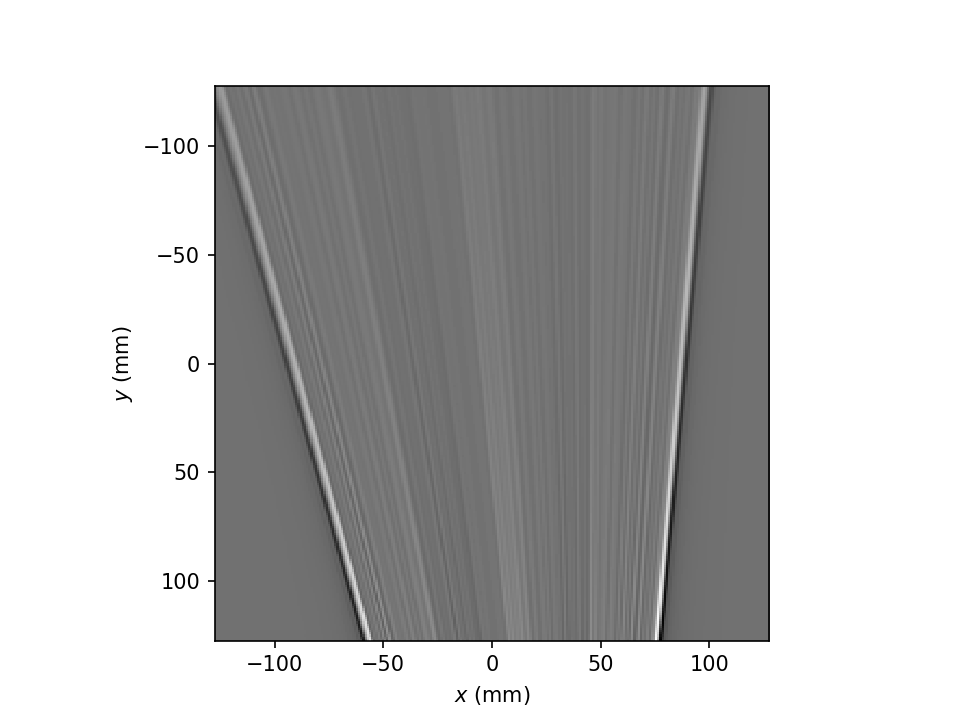

Text(0, 0.5, '$y$ (mm)')

In [20]:
plt.figure()
plt.gray()
plt.imshow(img_partial.T, extent=[x[0,0],x[Imsize-1,0],y[0,0],y[0,Imsize-1]])
plt.xlabel(r"$x$ (mm)")
plt.ylabel(r"$y$ (mm)")

Just try to change the interpolation type from ```cubic``` to  ```nearest``` to see the effect on this partial single-view reconstruction. It is also useful to try changing the projection ID (from 5 to whatever ID between 0 and ```N_ang-1```) to see that the backprojection follows exactly the direction of the physical projection during the acquisition.

### Backprojection (full)

Now we will just extend the previous example by looping through all the available views in the sinogram. We will use the variable ```ang_subsampling``` just to evaluate the effect of taking only a subset of projections, angularly equispaced.

In [21]:
# By these three variables, we can control
# the angular range and step in backprojection
ang_subsampling = 1
first_ang = 0
last_ang = N_ang

# Destination image
img_fbp = np.zeros([Imsize,Imsize], dtype=float)

# Define the sets of filtered projections and related grantry angles
s_filt=filtsino[:,first_ang:last_ang:ang_subsampling,0]
angs=np.deg2rad(beta_deg)[first_ang:last_ang:ang_subsampling]


The backprojection works exactly as we have done before in the single-view example, but now this step is inside a ```for``` loop over all the pairs ```(filtered_proj, beta_rad)```:

In [22]:
# Iterate over all the selected projections
i=0
for (filtered_proj, beta_rad) in zip(s_filt.T, angs):
    i += 1
    print("Backprojecting angle " + str(i) + "/" + str(len(angs)), end = "\r")
    U = D + r * np.sin(varphi-beta_rad)
    u = r * np.cos(varphi-beta_rad) * D / U
    W_BP = np.square(U)    
    
    # Accumulate the weighted values in the destination image
    img_fbp += interp1d(
        x = u_det,
        y = filtered_proj,
        kind = 'cubic',
        bounds_error = False,
        fill_value = 0,
        assume_sorted = False
    ) (u) / W_BP

    

And then we display the results as done before:

<IPython.core.display.Javascript object>


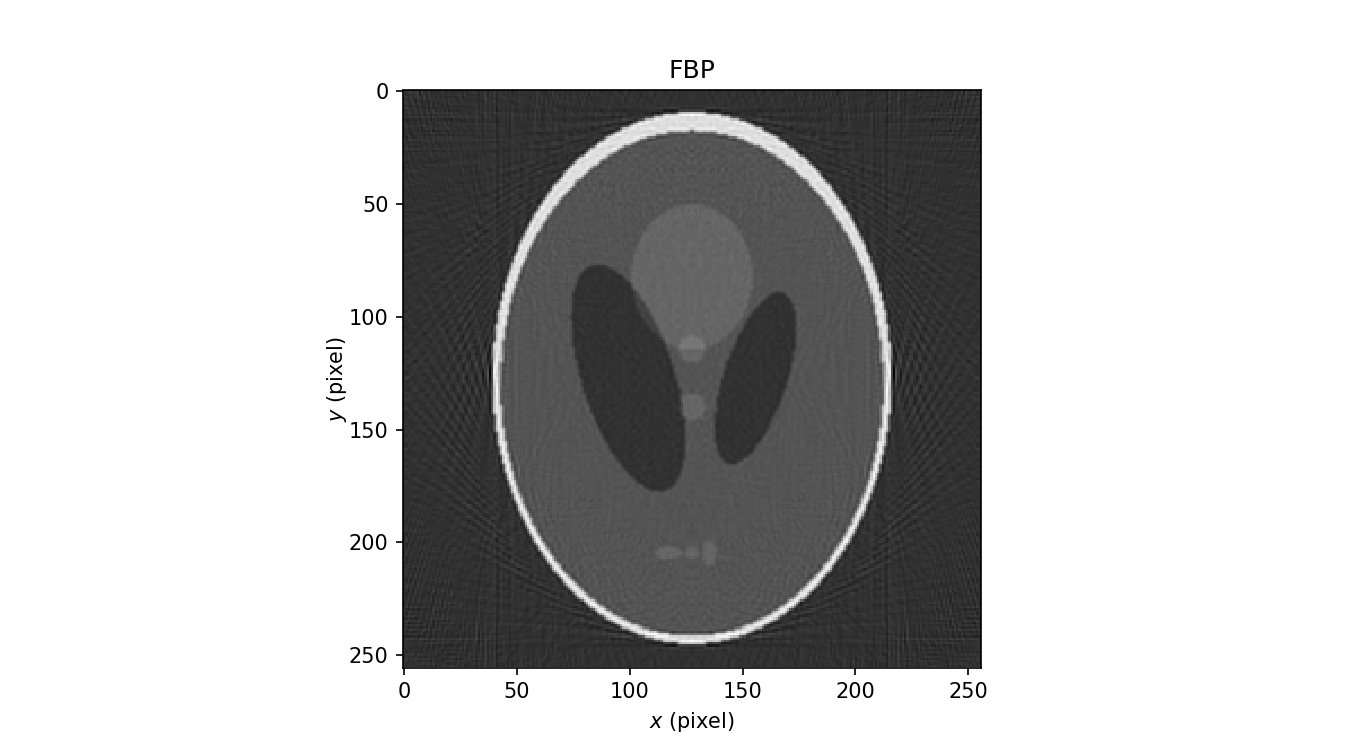

In [23]:
plt.figure(figsize=(9,5))
plt.gray()
plt.title("FBP")
plt.xlabel(r"$x$ (pixel)")
plt.ylabel(r"$y$ (pixel)", labelpad = 0)
plt.imshow(img_fbp.T)

#plt.savefig("FBP_fanbeam.pdf", bbox_inches='tight', pad_inches=0)

### FBP (partial, incomplete arcs)

In this last part of this notebook, we will define two auxiliary functions allowing us to generate subplots of partial reconstructions with a single line of code. The first function, ```PartialBP```, takes as arguments the initial and last gantry angle to be used in the reconstruction, the angular subsampling factor (with the same meaning of the full reconstruction done in the previous cells), and of course the sinogram and target image. The second function ```CreatePartialBPSubplot``` calls the first one, and it also contains the code required to make a subplot of the results.

In [24]:
def PartialBP(first_ang_id, last_ang_id, ang_subsampling, sino, dest_img, reset_img=False):

    s_filt1=sino[:,first_ang_id:last_ang_id:ang_subsampling,0]
    angs=np.deg2rad(beta_deg)[first_ang_id:last_ang_id:ang_subsampling]

    if(reset_img==True):
        dest_img.fill(0)
    
    for (filtered_proj, beta_rad) in zip(s_filt1.T, angs):
        U = D + r * np.sin(varphi-beta_rad)
        u = r * np.cos(varphi-beta_rad) * D / U
        W_BP = np.square(U)    

        dest_img += interp1d(
            x = u_det,
            y = filtered_proj,
            kind = 'linear',
            bounds_error = False,
            fill_value = 0,
            assume_sorted = False
        ) (u) / W_BP
        
    
def CreatePartialBPSubplot(first_ang_id, last_ang_id, ang_subsampling, sino, subplt_id, subplt_title):
    partial_img = np.zeros([Imsize,Imsize], dtype='float')
    PartialBP(first_ang_id = first_ang_id,
          last_ang_id = last_ang_id,
          ang_subsampling = ang_subsampling,
          sino = sino, 
          dest_img = partial_img, 
          reset_img=True)
    
    plt.subplot(subplt_id)
    plt.imshow(partial_img.T, extent=[x[0,0],x[Imsize-1,0],y[0,0],y[0,Imsize-1]])
    plt.title(subplt_title)
    plt.xlabel(r"$x$ (mm)")
    plt.ylabel(r"$y$ (mm)", labelpad = 0)


We will now create a figure composed of four subplots, with four different angular ranges to see how the final FBP image is formed when accumulating the projections.

<IPython.core.display.Javascript object>


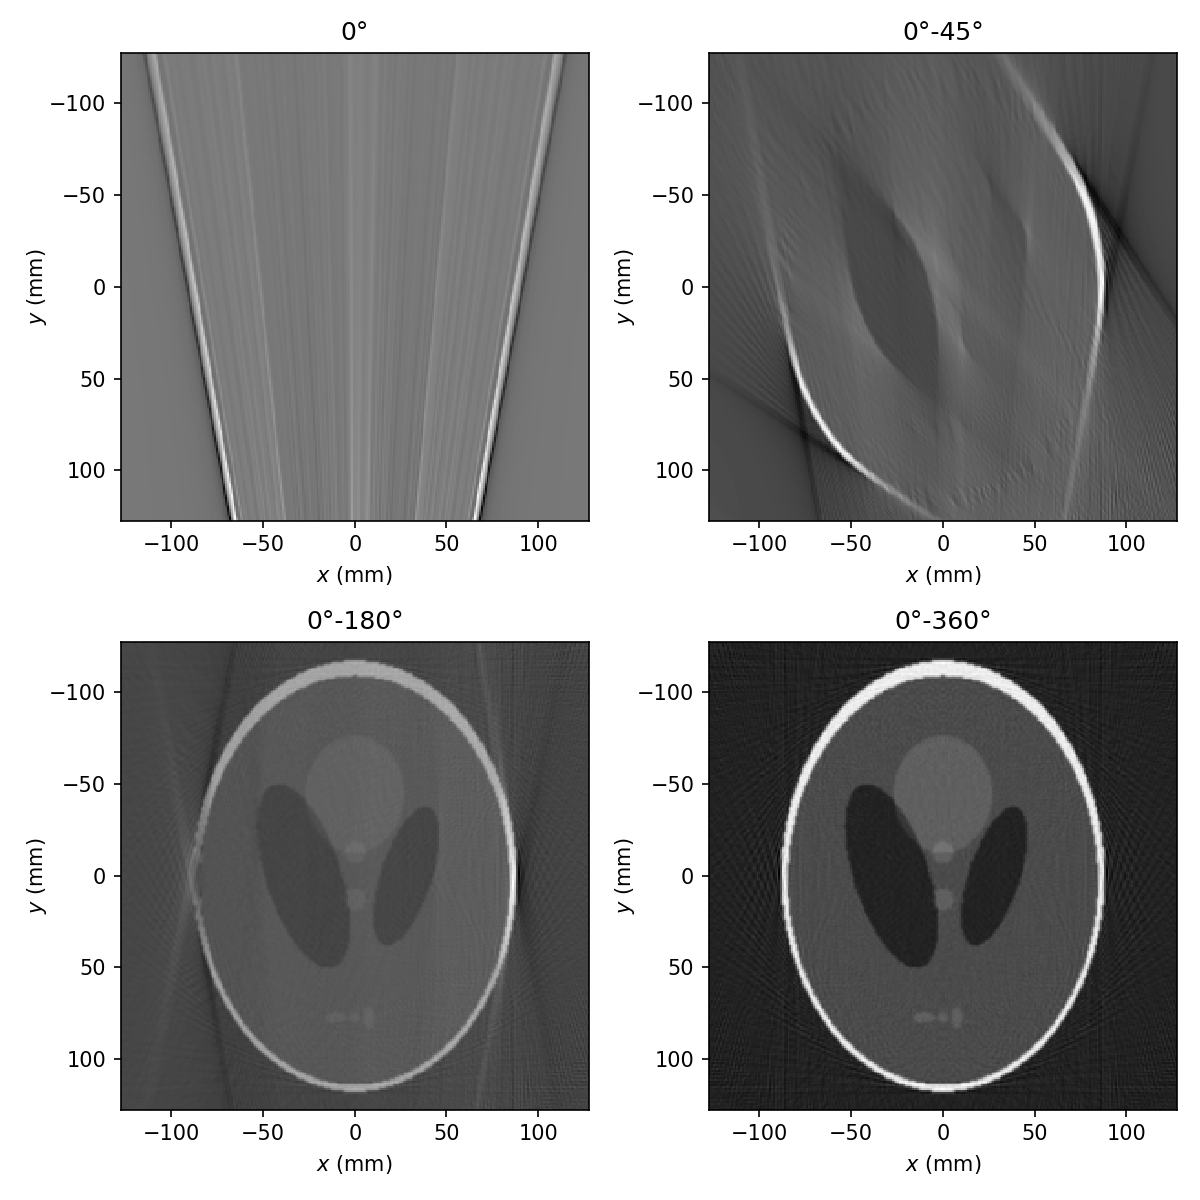

In [25]:
plt.figure(figsize=(8,8))
plt.gray()
CreatePartialBPSubplot(0,1,1,filtsino,221,"0°")
CreatePartialBPSubplot(0,45,1,filtsino,222,"0°-45°")
CreatePartialBPSubplot(0,180,1,filtsino,223,"0°-180°")
CreatePartialBPSubplot(0,360,1,filtsino,224,"0°-360°")
plt.tight_layout()

#plt.savefig("FBP_fanbeam_partialarcs.pdf", bbox_inches='tight', pad_inches=0)

The reader is invited to change the parameters used above to see the effect of changing, e.g., the angular range, the interpolation type, the angular subsampling, etc.